<b>1</b> OBTENCIÓN DE DATOS

In [1]:
import definirCorrelacionVariables
from matplotlib import pyplot
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
import numpy as np
import pylab as pl

data= definirCorrelacionVariables.getDataFromDataBase()

1172
key  ndvi len  1172
key  volImage len  1172
key  areaImage len  1172
key  hImage len  1172
key  dataIafNdvi len  1172
key  maxRed len  1172
key  minRed len  1172
key  maxBlue len  1172
key  meanRed len  1172
key  minBlue len  1172
key  maxGreen len  1172
key  meanBlue len  1172
key  minGreen len  1172
key  meanGreen len  1172
key  varianceRed len  1172
key  maxHistGrVal len  1172
key  maxHistValue len  1172
key  varianceBlue len  1172
key  maxHistBluVal len  1172
key  varianceGreen len  1172
key  criMean len  1172
key  criMax len  1172
key  criMin len  1172
key  cgreenviMean len  1172
key  cgreenviMax len  1172
key  cgreenviMin len  1172
key  cnirviMean len  1172
key  cnirviMax len  1172
key  cnirviMin len  1172
key  gndviMean len  1172
key  gndviMax len  1172
key  gndviMin len  1172
key  mcariOneMean len  1172
key  mcariOneMax len  1172
key  mcariOneMin len  1172
key  mtviOneMean len  1172
key  mtviOneMax len  1172
key  mtviOneMin len  1172
key  ngrdiMean len  1172
key  ngrdiMax 

<b>2</b> pre PROCESAMIENTO DE DATA

In [2]:
dataframe,datos,dictGeneral = definirCorrelacionVariables.generarMatrizDatos(data,True)

103


3. OBTENCIÓN DE CORRELACIÓN MÚLTIPLE

GRAFICAS ENTRE VARIABLES

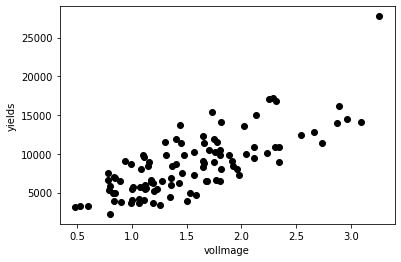

In [3]:
#pyplot.scatter(datos.datosVolumen, datos.datosVolumenCalculado,c="red")
#pyplot.scatter(datos.datosArea, datos.datosAreaCalculada,c="red")
#pyplot.scatter(datos.datosNdvi, datos.datosVolumenCalculado,c="blue")
#pyplot.scatter(datos.datosAltura, datos.datosNdvi,c="green")
pyplot.scatter(dataframe["volImage"],dataframe["yields"],c="black")
pyplot.xlabel("volImage")
pyplot.ylabel("yields")

pyplot.show()

SE CALCULA LA VARIABLE EL IAF
$Ac = \pi*r*g $

$g = \sqrt(h^2 + r^2) $

Se tiene que $r = Di/2$

$Ac = \pi*r*\sqrt(h^2 + r^2)$

$Ac = \pi*\frac{Di}{4}*\sqrt(4*h^2 + Di^2)$

Diametro

$diameter = 2*\sqrt(\frac{area}{\pi})$

In [4]:

import math
areaLateral = []
volumeFromDiameter = []
diametros=[]
for index,x in enumerate(datos.datosArea):
    diametro = 2*math.sqrt(x/math.pi)
    diametros.append(diametro)
    altura= datos.datosAlturaCalculada[index]/100
    valueAreaLateral=diametro*math.sqrt((diametro*diametro)+4*(altura*altura))
    valueVolume = math.pi*diametro*diametro*altura*(1/6)
    volumeFromDiameter.append(valueVolume)
    areaLateral.append(valueAreaLateral)


<b style="color:orange;">LAI CALCULATED FROM EQUATION BASED ON VOLUME and AREA</b>

Se calcula el IAF usando Volumen Imagen y Yield

$IAF =  0.0134 + 2.7791 Vc$

Se calcula IAF usando Area Lateral y Yield

$IAF =  -0.5786 + 0.7896 Alat $


In [5]:

IAF_from_volume = definirCorrelacionVariables.objective(datos.datosVolumenImagen, 2.7791,0.0134)
IAF_from_area = definirCorrelacionVariables.objective(areaLateral, 0.7896,-0.5786)
d = {"latArea":areaLateral, "IAF_VOL":IAF_from_volume, "laiLatArea":IAF_from_area}
dictGeneral.update(d)
dframeFinal = pd.DataFrame(data=dictGeneral)
pd.options.display.float_format = '{:,.2f}'.format
dataFrameCorrs=dframeFinal.loc[:,["yields","volImage","maxRed","maxBlue","varianceBlue","criMax","maxGreen"]]
dfCors= dataFrameCorrs.corr(method="pearson")
dfCors.round(decimals=3)
print(dfCors)
dfCors.to_latex("CorrelationsTabVariablesYieldPredict1.tex")
dataFrameCorrs=dframeFinal.loc[:,["yields","mtviOneMean",'ndviMean','laiLatArea','saviMax','tviMax','ndviMax']]
dfCors= dataFrameCorrs.corr(method="pearson")
dfCors.round(decimals=3)
print(dfCors)
dfCors.to_latex("CorrelationsTabVariablesYieldPredict2.tex")

              yields  volImage  maxRed  maxBlue  varianceBlue  criMax  \
yields          1.00      0.76    0.46     0.41          0.49    0.51   
volImage        0.76      1.00    0.33     0.23          0.52    0.43   
maxRed          0.46      0.33    1.00     0.71          0.51    0.92   
maxBlue         0.41      0.23    0.71     1.00          0.45    0.52   
varianceBlue    0.49      0.52    0.51     0.45          1.00    0.50   
criMax          0.51      0.43    0.92     0.52          0.50    1.00   
maxGreen        0.47      0.37    0.93     0.62          0.59    0.90   

              maxGreen  
yields            0.47  
volImage          0.37  
maxRed            0.93  
maxBlue           0.62  
varianceBlue      0.59  
criMax            0.90  
maxGreen          1.00  
             yields  mtviOneMean  ndviMean  laiLatArea  saviMax  tviMax  \
yields         1.00         0.07      0.36        0.77     0.32    0.32   
mtviOneMean    0.07         1.00      0.66       -0.25     0.12  

<h1> USO DE CROSS VAL SCORE </h1>

<b style="color:red;">LINEAR REGRESSION SIMPLE VS MULTIPLE</b>




Non Standard Scaler

REGRESSION MODELS

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,MaxAbsScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.isotonic import IsotonicRegression
from sklearn.cross_decomposition import PLSRegression

cantCv=4
scoreDef = "r2" 
#scoreDef="accuracy"
#scoreDef = "explained_variance"
#scoreDef="neg_root_mean_squared_error"
dfsX=dframeFinal.loc[:,["volImage"]]
dframeFinal.head()
X_volumenNoScaled= dfsX.values
y_multiple = dframeFinal.yields.values

sc_X = MaxAbsScaler()
sc_y = MaxAbsScaler()
Xvolume = sc_X.fit_transform(X_volumenNoScaled)
yieldNoScaled=dframeFinal.yields.values.reshape(-1, 1)
y = sc_y.fit_transform(yieldNoScaled)
#y=y+1
#print(y)
dfsX=dframeFinal.loc[:,["volImage","maxRed","maxBlue","varianceBlue","criMax","maxGreen","mtviOneMean",'ndviMean','laiLatArea','saviMax','tviMax','ndviMax']]
X_multipleNoScaled= dfsX.values
sc_XMulti = MaxAbsScaler()
Xmulti = sc_XMulti.fit_transform(X_multipleNoScaled)

scores = cross_val_score(LinearRegression(),X_volumenNoScaled ,yieldNoScaled , scoring=scoreDef, cv=cantCv)
print( "Linear Regression Simple",scores)
print(np.mean(scores))

scores = cross_val_score(LinearRegression(),X_multipleNoScaled ,yieldNoScaled , scoring=scoreDef, cv=cantCv)
print( "Linear Regression Multiple",scores)
print(np.mean(scores))

scores = cross_val_score(PLSRegression(n_components=2),X_volumenNoScaled ,yieldNoScaled , scoring=scoreDef, cv=cantCv)
print( "PLSRegression Regression Simple",scores)
print(np.mean(scores))

scores = cross_val_score(PLSRegression(n_components=2),X_multipleNoScaled ,yieldNoScaled , scoring=scoreDef, cv=cantCv)
print( "PLSRegression Regression Multiple",scores)
print(np.mean(scores))

scores = cross_val_score(SVR(kernel="linear"),Xvolume ,y.ravel() , scoring=scoreDef, cv=cantCv)
print( "SVR Linear Simple",scores)
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))
scores = cross_val_score(SVR(kernel="linear"),Xmulti ,y.ravel() , scoring=scoreDef, cv=cantCv)
print( "SVR Linear Multiple",scores,np.mean(scores.reshape(-1,1)))
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(RandomForestRegressor(),Xvolume ,y.ravel() , scoring=scoreDef, cv=cantCv)
print("Simple Regressor Random forest  ")
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(RandomForestRegressor(),Xmulti ,y.ravel() , scoring=scoreDef, cv=cantCv)
print("Multi Regressor Random Forest ")
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(tree.DecisionTreeRegressor(),X_volumenNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("Decision Tree Simple Regressor")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(tree.DecisionTreeRegressor(),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("Decision Tree Multi Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(linear_model.SGDRegressor(loss="squared_epsilon_insensitive"),Xvolume ,y.ravel() , scoring=scoreDef, cv=cantCv)
print("SGD Simple Regressor Squared Error")
#print(scores)
#scores=scores-1
print(np.mean(scores))

print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(linear_model.SGDRegressor(loss="squared_error",penalty="elasticnet",learning_rate="adaptive"),Xmulti ,y.ravel() , scoring=scoreDef, cv=cantCv)
print("SGD Multi Regressor Squared Error")
#print(scores)
#scores=scores-1
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(linear_model.Lasso(),X_volumenNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("Lasso Simple Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(linear_model.Lasso(),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("Lasso Multi Regressor ")
#print(scores)
print(np.mean(scores))



scores = cross_val_score(ensemble.BaggingRegressor(),X_volumenNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("BaggingRegressor Simple Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(ensemble.BaggingRegressor(),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("BaggingRegressor Multi Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(ensemble.AdaBoostRegressor(loss="square"),X_volumenNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("AdaBoostRegressor Single Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(ensemble.AdaBoostRegressor(loss="square"),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("AdaBoostRegressor Multi Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(ensemble.ExtraTreesRegressor(criterion="absolute_error"),X_multipleNoScaled ,yieldNoScaled.ravel() , scoring=scoreDef, cv=cantCv)
print("ExtraTreesRegressor Multi Regressor ")
#print(scores)
print(np.mean(scores))

scores = cross_val_score(SVR(kernel="rbf"),Xvolume ,y.ravel() , scoring=scoreDef, cv=cantCv)
print( "SVR RBF Simple",scores)
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

scores = cross_val_score(SVR(kernel="rbf"),Xmulti ,y.ravel() , scoring=scoreDef, cv=cantCv)
print( "SVR RBF Multiple",scores)
print(np.mean(scores))
print(np.mean(sc_y.inverse_transform(scores.reshape(-1,1)*-1)))

Linear Regression Simple [0.68226567 0.58475797 0.30322008 0.54257341]
0.5282042842263209
Linear Regression Multiple [0.70675782 0.59128678 0.42330182 0.38342397]
0.5261925977026363
PLSRegression Regression Simple [0.68226567 0.58475797 0.30322008 0.54257341]
0.528204284226321
PLSRegression Regression Multiple [0.79223153 0.69562722 0.48876317 0.74497823]
0.6804000384566546
SVR Linear Simple [0.69945514 0.58941621 0.34854857 0.54126057]
0.5446701192230544
-15118.322498729183
SVR Linear Multiple [0.77109128 0.69258181 0.41725301 0.65523135]

c:\Users\Julian Bolanos\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\cross_decomposition\_pls.py:236: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
c:\Users\Julian Bolanos\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\cross_decomposition\_pls.py:236: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
c:\Users\Julian Bolanos\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\cross_decomposition\_pls.py:236: FutureWarning: As of version 0.24, n_components(2) should be in [1, n_features].n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  FutureWarning,
c:\Users\Julian Bolanos\AppData\Local\Programs\Pytho

 0.6340393623146006
0.6340393623146006
-17598.93046828811
Simple Regressor Random forest  
0.3284543064785447
-9116.854323718679
Multi Regressor Random Forest 
0.5546120392369951
-15394.278802779292
Decision Tree Simple Regressor
0.08511106468770693
Decision Tree Multi Regressor 
0.047239442586825886
SGD Simple Regressor Squared Error
0.25113014923708754
-6970.579900245014
SGD Multi Regressor Squared Error
0.4215491740143592
-11700.873862720671
Lasso Simple Regressor 
0.528272649624141
Lasso Multi Regressor 
0.6254059257805695
BaggingRegressor Simple Regressor 
0.3120801399653558
BaggingRegressor Multi Regressor 
0.5273916782288196
AdaBoostRegressor Single Regressor 
0.3181068995218495
AdaBoostRegressor Multi Regressor 
0.5137461627534704
ExtraTreesRegressor Multi Regressor 
0.5217147924198438
SVR RBF Simple [0.49709592 0.60214719 0.29374538 0.33751607]
0.432626136634873
-12008.335365184175
SVR RBF Multiple [0.74033896 0.45126562 0.44991141 0.52644958]
0.5419913932859619
-15043.9695258